In this notebook, I introduce how to estimate survival and abundance with spatial Jolly-Seber models (SJS). SJS models assume that animals are more likely to be encountered near their activity centers (average location during the study period). As such, the

In [1]:
%config InlineBackend.figure_format = 'retina'

# this suppresses a warning about the cuda backend 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from itertools import product

from jax import random, debug
from jax.scipy.special import logit
from numpyro.contrib.control_flow import scan
from numpyro.infer import NUTS, MCMC, Predictive
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns

# plotting defaults
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
sns.set_palette("tab10")

# mcmc hyperparameters
WARMUP_COUNT = 500
SAMPLE_COUNT = 1000
CHAIN_COUNT = 3
RANDOM_SEED = 1792

# simulation hyperparameters
SEASON_COUNT = 7
SUPERPOPULATION_SIZE = 400
APPARENT_SURVIVAL = 0.7
INITIAL_PI = 0.34
BASELINE_RATE = 0.25
SIGMA = 0.5
M = 1000
GRID_WIDTH = 10
OCCASION_COUNT = 20
BUFFER = 2
U_SIGMA = 5

# make the labels on arviz plots nicer
labeller = az.labels.MapLabeller(
    var_name_map={"psi": r"$\psi$", 'gamma':  r"$\gamma$", 'alpha': r'$\alpha$',
                  'epsilon': r"$\epsilon$", 'p':  r"$p$" , 'beta': r'$\beta$',
                  'phi': r'$\phi$', 'alpha_t': r'$\alpha_t$',}
)

def sim_js():
    """Simulate capture histories with a spatial Jolly-Seber model.

    Simulation code adapted from Kery and Schaub (2012), Chapter 10 and Gardner
    et al (2017) via Olivier Gimenez:
    https://oliviergimenez.github.io/basics_spatial_capturerecapture/
    """

    rng = np.random.default_rng(RANDOM_SEED)
    interval_count = SEASON_COUNT - 1

    # simulate entry into the population
    pi_rest = (1 - INITIAL_PI) / interval_count
    pi = np.concatenate([[INITIAL_PI], np.full(interval_count, pi_rest)])

    # which occasion did the animal enter in?
    entry_matrix = rng.multinomial(n=1, pvals=pi, size=SUPERPOPULATION_SIZE)
    entry_occasion = entry_matrix.nonzero()[1]
    _, entrant_count = np.unique(entry_occasion, return_counts=True)

    # zero if the animal has not yet entered and one after it enters
    entry_trajectory = np.maximum.accumulate(entry_matrix, axis=1)

    # flip coins for survival between occasions
    survival_draws = rng.binomial(
        1, APPARENT_SURVIVAL, (SUPERPOPULATION_SIZE, interval_count)
    )

    # add column such that survival between t and t+1 implies alive at t+1
    survival_draws = np.column_stack([np.ones(SUPERPOPULATION_SIZE), survival_draws])

    # ensure that the animal survives until it enters
    is_yet_to_enter = np.arange(SEASON_COUNT) <= entry_occasion[:, None]
    survival_draws[is_yet_to_enter] = 1

    # once the survival_draws flips to zero the remaining row stays 0
    survival_trajectory = np.cumprod(survival_draws, axis=1)

    # animal has entered AND is still alive
    state = entry_trajectory * survival_trajectory
    state = state.astype(np.int8)

    # create the trapping grid
    grid_height = GRID_WIDTH
    grid = product(range(GRID_WIDTH), range(grid_height))
    grid = np.array(list(grid))
    trap_count = len(grid)

    # define the state space
    minima = grid.min(axis=0) - BUFFER
    maxima = grid.max(axis=0) + BUFFER

    # simulate activity centers for every individual in the superpopulation
    center_coords = rng.uniform(minima, maxima, size=(SUPERPOPULATION_SIZE, 2))

    # true distance between the trap and the activity centers
    distance = jnp.linalg.norm(
        center_coords[:, None, :] - grid[None, :, :],
        axis=2
    )

    # simulate potential captures
    p = BASELINE_RATE * np.exp(-(distance**2) / (2 * SIGMA**2))
    capture = rng.binomial(OCCASION_COUNT, p[..., None],
                           size=(SUPERPOPULATION_SIZE, trap_count, SEASON_COUNT))

    # calculate actual captures, shape: (super_size, trap_count, season_count)
    capture_history = capture * state[:, np.newaxis, :]

    # remove the non-detected individuals
    was_captured = capture_history.sum(axis=(1, 2)) > 0
    capture_history = capture_history[was_captured]

    # augment the history with nz animals
    n = was_captured.sum()
    nz = M - n
    all_zero_history = np.zeros((nz, trap_count, SEASON_COUNT), dtype=np.int8)
    capture_history = np.vstack([capture_history, all_zero_history]).astype(np.int8)

    # return a dict with relevant summary stats
    N_t = state.sum(axis=0)

    # deaths at time t
    D_t = (state[:, :-1] * (1 - state[:, 1:])).sum(axis=0)

    # Print simulation summary
    print(f"Simulation complete: {n}/{SUPERPOPULATION_SIZE} individuals detected")
    print(f"Population trajectory: N = {N_t}")
    print(f"Recruits per season: B = {entrant_count}")
    print(f"Deaths per season: D = {D_t}")

    return {
        'capture_history': capture_history,
        'N_t': N_t,
        'B': entrant_count,
        'trapxy': grid,
        'trap_count': trap_count,
        'center_coords': center_coords,
        'z': state,
        'minima': minima,
        'maxima': maxima,
        'super_size': M,
        'occasion_count': OCCASION_COUNT,
        'season_count': SEASON_COUNT
    }

In [2]:
def spatial_js(data):

    # unpack everything in the data dictionary
    history = data['capture_history']
    trapxy = jnp.array(data['trapxy'])
    trap_count = data['trap_count']
    xmin, ymin = jnp.array(data['minima'])
    xmax, ymax = jnp.array(data['maxima'])
    super_size = data['super_size']
    occasion_count = data['occasion_count']
    season_count = data['season_count']

    # apparent survival
    phi = numpyro.sample('phi', dist.Uniform(0, 1))

    # parameterize the  entry probabilities in terms of pi and psi
    psi = numpyro.sample('psi', dist.Uniform(0, 1))
    pi = numpyro.sample('pi', dist.Dirichlet(jnp.ones(season_count)))

    # compute the removal probabilities as a function of psi and pi
    gamma = jnp.zeros(season_count)

    # the `vector.at[0].set(1)` notation is jax for `vector[0] = 1`
    gamma = gamma.at[0].set(psi * pi[0])
    for t in range(1, season_count):
        denominator = jnp.prod(1 - gamma[:t])
        gamma = gamma.at[t].set(psi * pi[t] / denominator)
    gamma = numpyro.deterministic('gamma', gamma)

    # parameters related to detection
    g0 = numpyro.sample('g0', dist.Uniform(0, 1))
    sigma = numpyro.sample('sigma', dist.Uniform(0, U_SIGMA))

    # functions of the natural parameters
    alpha0 = logit(dist.util.clamp_probs(g0))
    alpha1 = 1 / (2 * sigma**2)

    # Sample activity centers ONCE per animal (outside scan)
    with numpyro.plate("animals_spatial", super_size):
        sx = numpyro.sample('sx', dist.Uniform(xmin, xmax))
        sy = numpyro.sample('sy', dist.Uniform(ymin, ymax))
        center_coords = jnp.stack([sx, sy], axis=1)

        # pairwise distance between activity centers and the traps
        distance = jnp.linalg.norm(
            center_coords[:, None, :] - trapxy[None, :, :],
            axis=-1
        )

        # # cloglog version
        # lm = jnp.exp(alpha0 - alpha1*distance**2)
        # p = 1 - jnp.exp(-lm)
        p = g0 * jnp.exp(-(distance**2) / (2 * sigma**2))

    def transition_and_capture(carry, y_current):

        z_previous, t = carry

        # transition probability matrix
        trans_probs = jnp.array([
            [1 - gamma[t], gamma[t],     0.0],  # From not yet entered
            [         0.0,      phi, 1 - phi],  # From alive
            [         0.0,      0.0,     1.0]   # From dead
        ])

        with numpyro.plate("animals", super_size, dim=-1):

            mu_z_current = trans_probs[z_previous]
            z_current = numpyro.sample(
                "state",
                dist.Categorical(dist.util.clamp_probs(mu_z_current)),
                infer={"enumerate": "parallel"}
            )

            mu_y_current = jnp.where(z_current == 1, 1, 0) * p.T
            mu_y_current = dist.util.clamp_probs(mu_y_current)

            with numpyro.plate('traps', trap_count, dim=-2):
                numpyro.sample(
                    "obs",
                    dist.Binomial(occasion_count, mu_y_current),
                    obs=y_current.T
                )

        return (z_current, t + 1), None

    # start everyone in the not yet entered state
    state_init = jnp.zeros(super_size, dtype=jnp.int32)
    scan(
        transition_and_capture,
        (state_init, 0),
        np.moveaxis(history, 2, 0)
    )

sim_data = sim_js()

Simulation complete: 300/400 individuals detected
Population trajectory: N = [133 124 128 145 138 162 154]
Recruits per season: B = [133  33  44  54  37  57  42]
Deaths per season: D = [42 40 37 44 33 50]


In [3]:
rng_key = random.PRNGKey(RANDOM_SEED)

# specify which sampler you want to use
nuts_kernel = NUTS(spatial_js)

# configure the MCMC run
mcmc = MCMC(nuts_kernel, num_warmup=WARMUP_COUNT, num_samples=SAMPLE_COUNT,
            num_chains=CHAIN_COUNT)

# run the MCMC 
mcmc.run(rng_key, sim_data)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

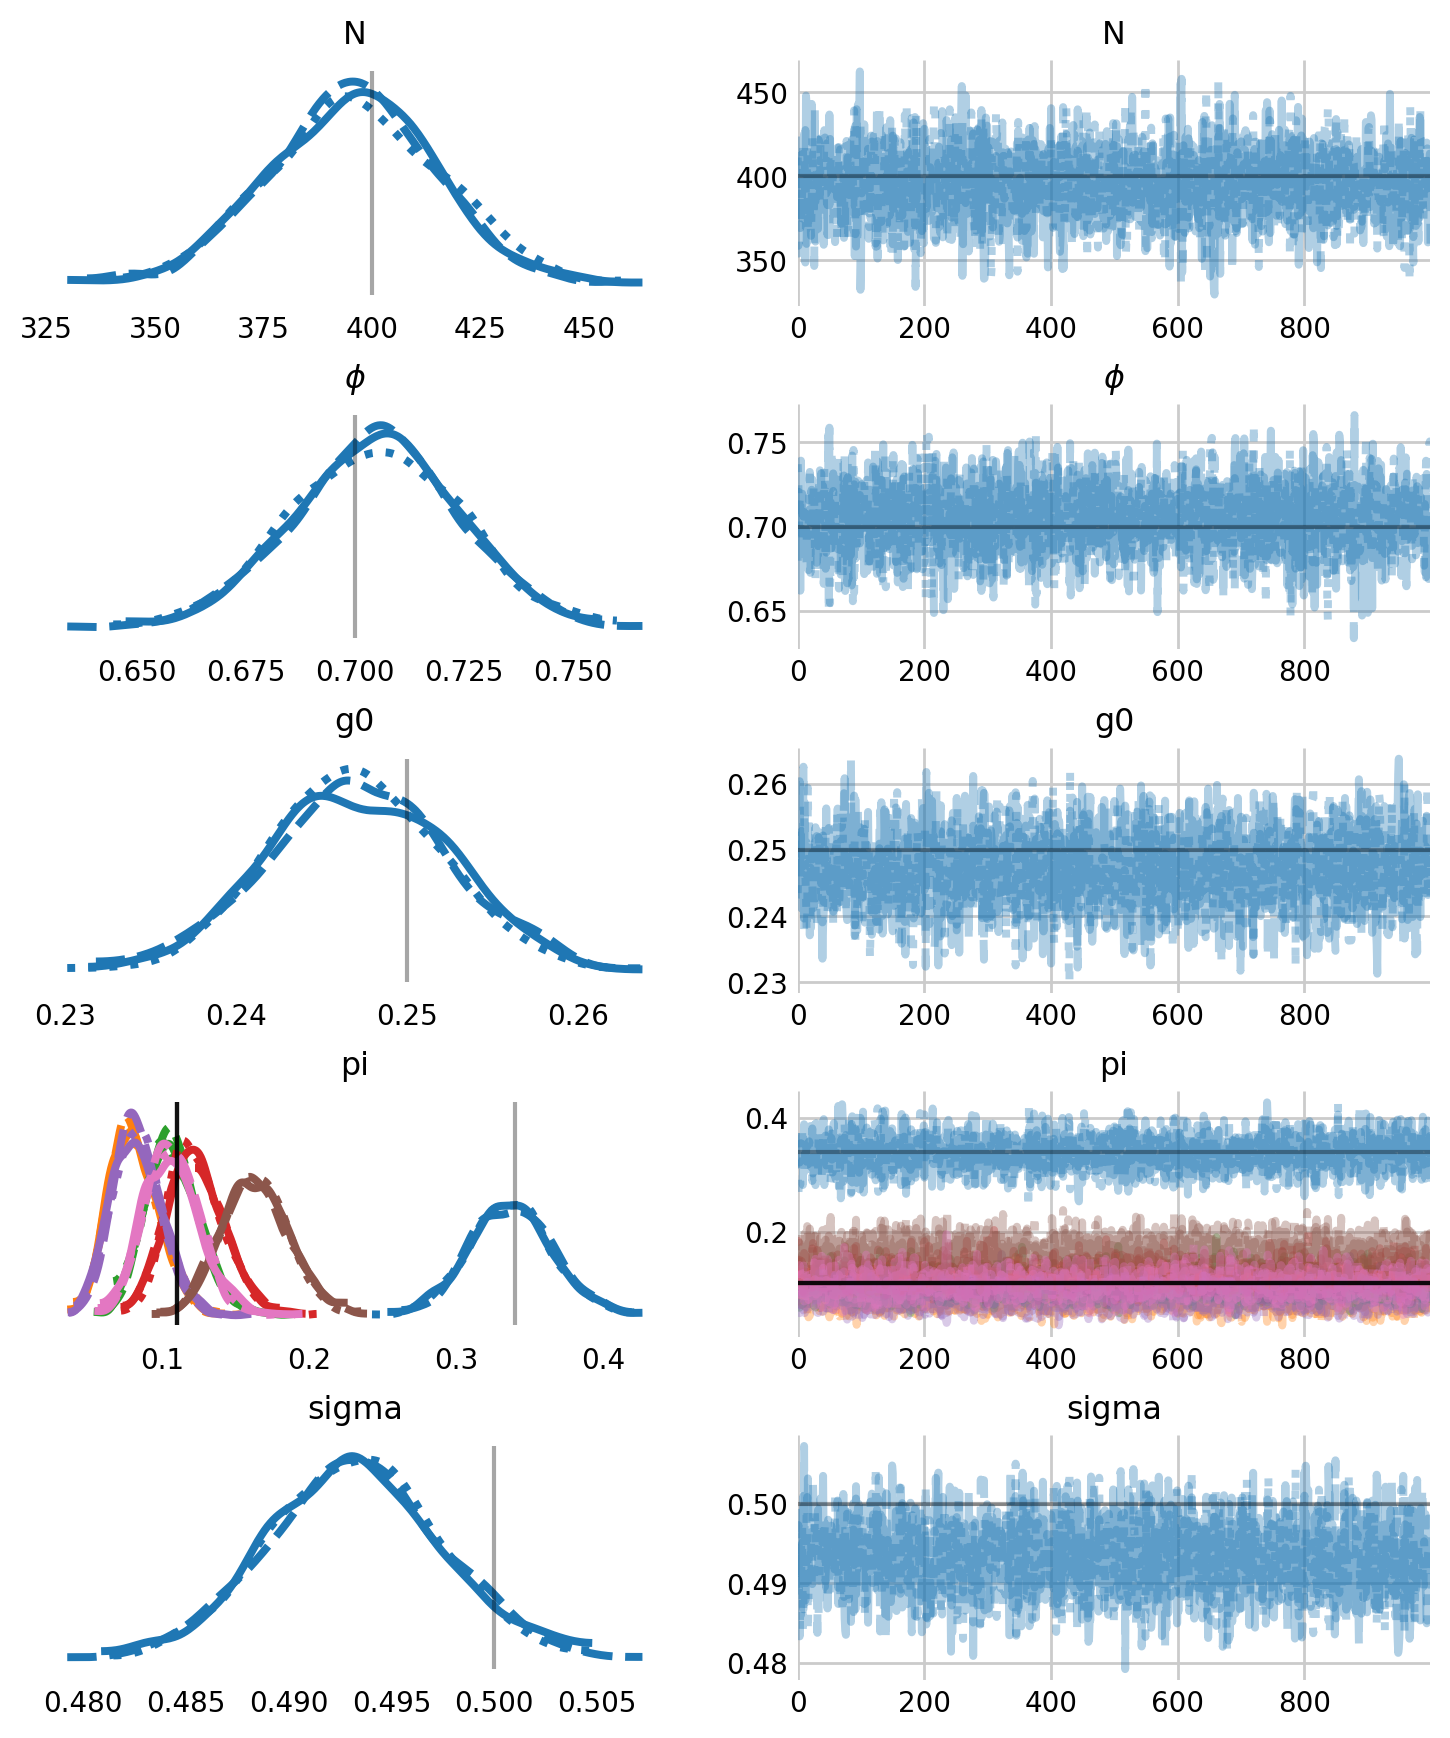

In [4]:
samples = mcmc.get_samples(group_by_chain=True)
idata = az.from_dict(samples)
idata.posterior['N'] = idata.posterior['psi'] * M

pi_rest = (1 - INITIAL_PI) / (SEASON_COUNT - 1)
pi = np.concat([[INITIAL_PI], np.full(SEASON_COUNT - 1, pi_rest)])

parameters = ['N', 'phi', 'g0', 'pi', 'sigma']
axes = az.plot_trace(
    idata,
    figsize=(8,10),
    var_names=parameters,
    labeller=labeller,
    lines=[("phi", {}, [APPARENT_SURVIVAL]), ("g0", {}, [BASELINE_RATE]),
           ("pi", {}, pi), ("N", {}, [SUPERPOPULATION_SIZE]),
           ('sigma', {}, SIGMA)],
)
plt.subplots_adjust(hspace=0.4)
[axes[i, 0].grid(False) for i in range(len(parameters))]
plt.show()

In [5]:
def sample_z(model, posterior_samples, data):
    '''Samples the posterior predictive distribution for z given the histories'''

    # initialize the posterior predictive distribution
    predictive = Predictive(
        model,
        posterior_samples=posterior_samples,
        return_sites=["state"]
    )

    # sample z
    rng_key = random.PRNGKey(RANDOM_SEED)
    latent_samples = predictive(rng_key, data)
    return latent_samples["state"]

# generate the posterior predictive distribution for N
samples = mcmc.get_samples()
z = sample_z(spatial_js, samples, sim_data)
ever_alive = z.max(axis=1) > 0
samples['N'] = ever_alive.sum(axis=1)

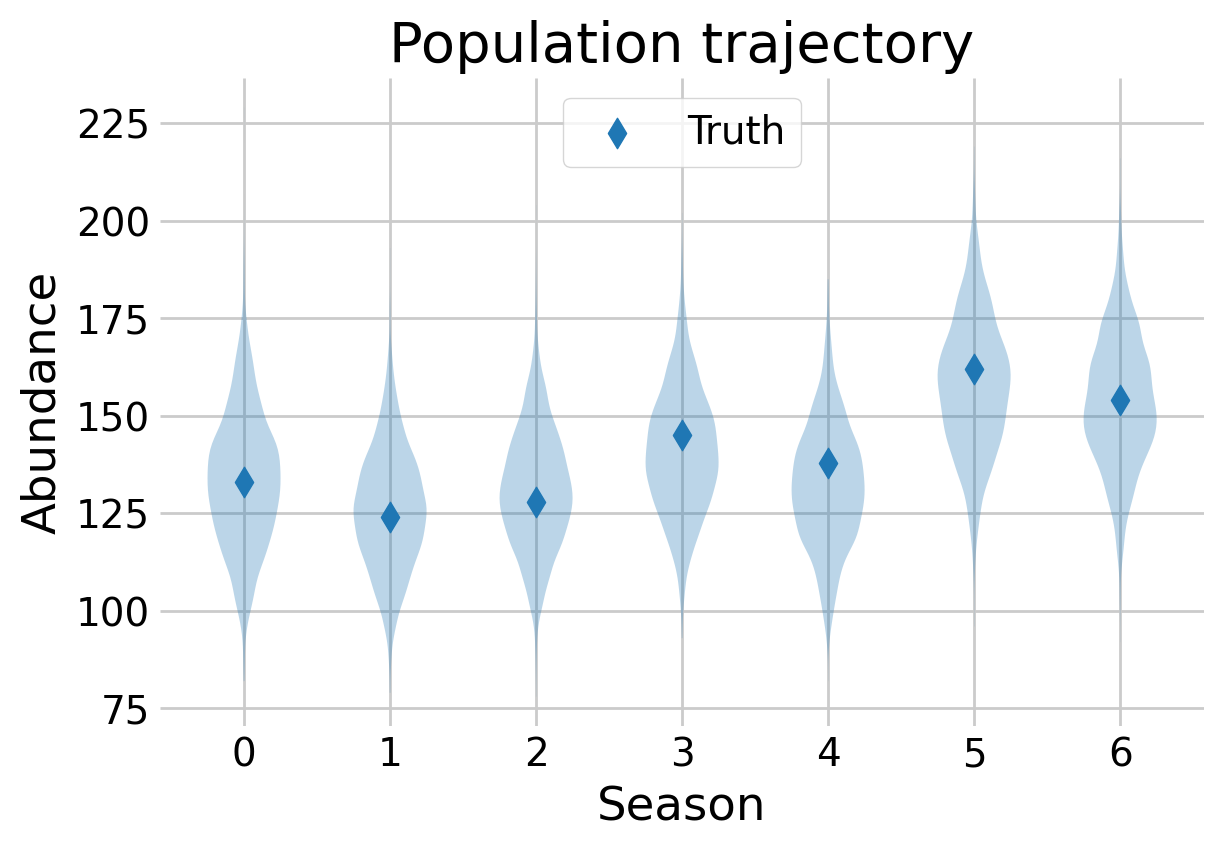

In [6]:
fig, ax = plt.subplots(figsize=(6,4))

t = np.arange(SEASON_COUNT)

N_t_samps = (z == 1).sum(axis=2)

ax.scatter(t, sim_data['N_t'], color='C0', marker='d', label='Truth', s=60)
ax.violinplot(N_t_samps, t, showmedians=False, showextrema=False)

ax.legend()
ax.set_xlabel(r'Season')
ax.set_ylabel(r'Abundance')
ax.set_title(r'Population trajectory')

plt.show()